In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
URL = 'https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv'
df = pd.read_csv(URL)

In [ ]:
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


###¿Cuál es el tensor de la serie temporal?

####- Diaria, porque pasa de un dia a otro de manera exacta


In [ ]:
df_new = df.set_index('date')
#pasamos date como el indice del db porque la fecha es el tensor de la database,
#y creamos un nuevo df para usarlo en la verificacion Dickey-Fuller

<Axes: >

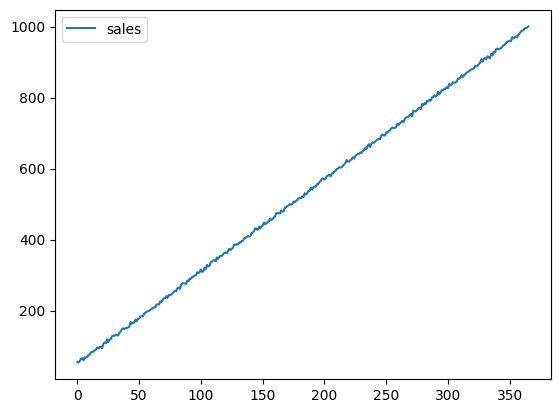

In [ ]:
df.plot()

###¿Cuál es la tendencia?
####- Creciente


---



In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_new["sales"],
                               model='additive',
                               period=7)

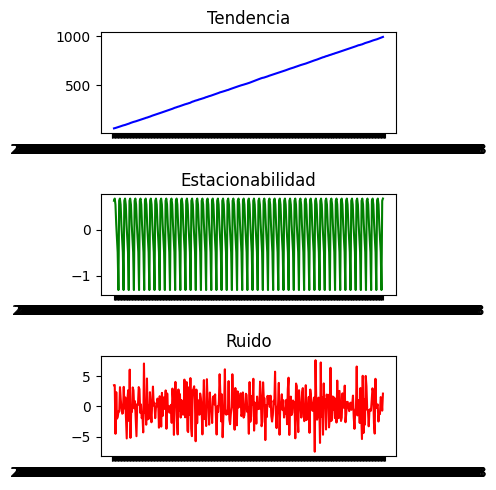

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(5, 5)) # 3 filas, 1 columna

axs[0].plot(decompose.trend, color='blue')
axs[0].set_title("Tendencia")

axs[1].plot(decompose.seasonal, color= 'green')
axs[1].set_title("Estacionabilidad")

axs[2].plot(decompose.resid, color='red')
axs[2].set_title("Ruido")

plt.tight_layout()
plt.show()

###¿Es estacionaria?
#### - No, porque la media cambia constantemente ya que la tendencia crece.

###¿Existe variabilidad o presencia de ruido?
- Si

---

###Verificamos la estacionabilidad con la prueba de Dickey-Fuller Aumentada

In [ ]:
#creamos una nuevo df que unicamente selecciona sales ya que df_new ya tiene dates como indice
df_time_series = df_new['sales']
df_time_series.head()

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test_result = adfuller(df_time_series)

print("ADF Statistic:", adf_test_result[0])
print("P-value:", adf_test_result[1])
print("Critical Values:")
for key, value in adf_test_result[4].items():
    print(f"  {key}: {value:.2f}")
#el for es para eliminar la descripcion del tipo de valor de Critical Values

ADF Statistic: 0.5454141937063742
P-value: 0.9861899815311063
Critical Values:
  1%: -3.45
  5%: -2.87
  10%: -2.57


###Interpretacion de valores:
* ADF = 0.5454
- El valor de la prueba resume qué tan no estacionaria parece ser la serie. Y entre más negativo sea el número, más probable es que la serie sea estacionaria. En este caso, parecer ser no estacionaria.

* P-value = 0.9862
- La probabilidad de que la serie NO sea estacionaria. Si es menor a 0.05 o 0.01 la serie SÍ será estacionaria. Pero en este caso, podemos decir que la serie no es estacionaria.

* Critical Values
- Umbrales de comparación. Si 'ADF' es más pequeño (más negativo) que los valores de aqui, es una señal de que la serie es estacionaria.

- PERO, el ADF actual (0.5454) es un número positivo, lo cual es mayor que cualquier valor critico negativo, confirmando que la serie se mantiene no estacionaria.

---

### Entrenamos un ARIMA

Utilizando los datos de entrenamiento para encontrar la mejor parametrización del modelo ARIMA

In [ ]:
from pmdarima import auto_arima

modelo = auto_arima(df['sales'], seasonal=False,
                    stepwise=True,
                    trace=True)
print(modelo.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.162, Time=3.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=2.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=1.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 10.723 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366


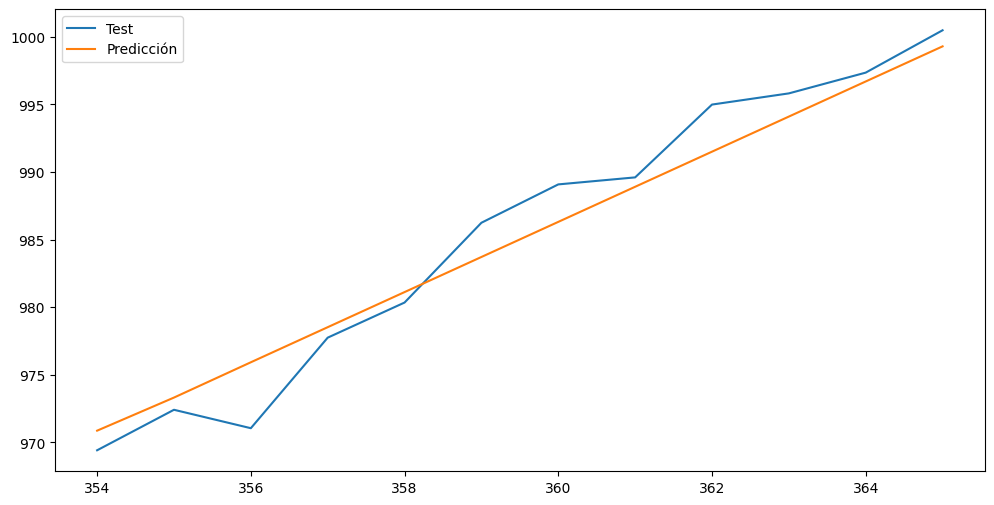

In [ ]:
train = df.iloc[:-12]  # Todo menos los últimos 12 meses
test = df.iloc[-12:]   # Últimos 12 meses

modelo = auto_arima(train['sales'], seasonal=False, stepwise=True)
predicciones = modelo.predict(n_periods=len(test))

# Comparar visualmente
plt.figure(figsize=(12,6))
plt.plot(test.index, test['sales'], label="Test")
plt.plot(test.index, predicciones, label="Predicción")
plt.legend()
plt.show()

#### La gráfica muestra que el modelo es capaz de capturar correctamente la tendencia general de las ventas en el período de prueba.

---



###PREDICCIONES

In [ ]:
from sklearn.metrics import mean_squared_error # Error Cuadrático Medio
import numpy as np

# evaluamos la precisión del modelo de predicción (ARIMA)
rmse = np.sqrt(mean_squared_error(test['sales'], predicciones))
print(f"RMSE: {rmse}")

RMSE: 2.2252506589437058


In [ ]:
min_sales = df_new['sales'].min()
max_sales = df_new['sales'].max()

print(min_sales)
print(max_sales)

53.803211351129065
1000.4827845048948


En promedio, las predicciones de ARIMA se desvian de los valores reales de 'Sales' en un 2.22 lo que significa que el modelo tiene buen rendimiento ya que las ventas en el df varian de 50 hasta 1,000 siendo 2.22 un error promedio muy bajo en comparacion con el rango de valores.

In [ ]:
from sklearn.metrics import mean_absolute_error # Error Absoluto Medio

mean_absolute_error(test['sales'], predicciones)
# Muestra la diferencia promedio entre las predicciones y los valores reales
# Entre más bajo mas preciso

1.8186643573838712

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error # Error Porcentual Absoluto Medio

mean_absolute_percentage_error(test['sales'], predicciones)
#calcula el error absoluto de cada valor real menos la prediccion,
#divide ese error absoluto por el valor real dando un error porcentual
#despues, calcula el promedio de todos los errores y los hace porcentajes (*100)


0.0018477575110326914

In [ ]:
#Predicciones a futuro (10)

forecast = modelo.predict(10)
forecast

,0
354,970.863923
355,973.312162
356,975.922979
357,978.518402
358,981.115282
359,983.712024
360,986.308779
361,988.905533
362,991.502288
363,994.099042


###CONCLUSION:

#### - Con base a los patrones aprendidos con train y test del modelo ARIMA; podemos concluir que los valores arrojados son una estimacion del modelo para los proximos 10 periodos, y estan alineados a la tendencia creciente de los datos historicos.